In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
########################################
### READ TREES AND CREATE DATAFRAMES ###
########################################


# fix random seed for reproducibility
np.random.seed(1986)

#create DataFrames with the values coming from the trees
file_tau = uproot.open('../bc_jpsi_tau_nu_gen.root')
tree_tau = file_tau['tree;1']
tau  = tree_tau.pandas.df(tree_tau.keys())

file_mu = uproot.open('../bc_jpsi_mu_nu_gen.root')
tree_mu = file_mu['tree;1']
mu  = tree_mu.pandas.df(tree_mu.keys())

In [3]:
############################################
### ADD NECESSARY FEATURES TO DATAFRAMES ###
############################################


#add the column target to both dataframes
mu ['target'] = 0
tau['target'] = 1

#add the columns of interesting features (taken from LHCb paper)
mu['m2_miss'] = 0 #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
tau['m2_miss'] = 0 
mu['muE_Brf'] = 0 #mu energy in the Bc rest frame
tau['muE_Brf'] = 0 
mu['q2'] = 0 #squared 4momentum transfer to lepton sys (p_B - p_mu1 - p_mu2)^2
tau['q2'] = 0
mu['pT_miss'] = 0 #misisng pT of the final state 
tau['pT_miss'] = 0

bc_vect = ROOT.TLorentzVector()
jpsi_vect = ROOT.TLorentzVector()
mu_vect = ROOT.TLorentzVector()
mu1_vect = ROOT.TLorentzVector()
mu2_vect = ROOT.TLorentzVector()
mu_mass = 0.10565837 #GeV/c^2
c = 2.99e8 #m/s


start = time.time()
i = 0
while i < mu['run'].count():
    bc_vect.SetPtEtaPhiM(mu.at[i,'bc_pt'],mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],mu.at[i,'bc_mass'])
    mu_vect.SetPtEtaPhiM(mu.at[i,'mu_pt'],mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(mu.at[i,'mu1_pt'],mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(mu.at[i,'mu2_pt'],mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)
    
    m2_vect = bc_vect - mu1_vect - mu2_vect - mu_vect
    q2_vect = bc_vect - mu1_vect - mu2_vect 
    
    mu.at[i,'m2_miss'] = m2_vect.Mag2()
    mu.at[i,'q2'] = q2_vect.Mag2()
    mu.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vect.Rapidity())
    mu.at[i,'pT_miss'] = m2_vect.Pt()
    
    i += 1
    
i = 0
while i < tau['run'].count():
    bc_vect.SetPtEtaPhiM(tau.at[i,'bc_pt'],tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],tau.at[i,'bc_mass'])
    mu_vect.SetPtEtaPhiM(tau.at[i,'mu_pt'],tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
    mu1_vect.SetPtEtaPhiM(tau.at[i,'mu1_pt'],tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
    mu2_vect.SetPtEtaPhiM(tau.at[i,'mu2_pt'],tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)
    
    m2_vect = bc_vect - mu1_vect - mu2_vect - mu_vect
    q2_vect = bc_vect - mu1_vect - mu2_vect
    
    tau.at[i,'m2_miss'] = m2_vect.Mag2()
    tau.at[i,'q2'] = q2_vect.Mag2()
    tau.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vect.Rapidity())
    tau.at[i,'pT_miss'] = m2_vect.Pt()
    
    i += 1
    
end = time.time()
print 'Running time to add the three new vars to the df = %.1f'%(end - start)

Running time to add the three new vars to the df = 490.1


Train on 48422 samples, validate on 48422 samples
Epoch 1/10
48422/48422 [==============================] - 9s 183us/step - loss: 0.5712 - acc: 0.6938 - val_loss: 0.5629 - val_acc: 0.7040
Epoch 2/10
48422/48422 [==============================] - 8s 166us/step - loss: 0.5585 - acc: 0.7092 - val_loss: 0.5616 - val_acc: 0.7040
Epoch 3/10
48422/48422 [==============================] - 8s 166us/step - loss: 0.5533 - acc: 0.7162 - val_loss: 0.5510 - val_acc: 0.7189
Epoch 4/10
48422/48422 [==============================] - 8s 168us/step - loss: 0.5466 - acc: 0.7248 - val_loss: 0.5430 - val_acc: 0.7275
Epoch 5/10
48422/48422 [==============================] - 8s 166us/step - loss: 0.5374 - acc: 0.7331 - val_loss: 0.5357 - val_acc: 0.7306
Epoch 6/10
48422/48422 [==============================] - 8s 166us/step - loss: 0.5263 - acc: 0.7399 - val_loss: 0.5230 - val_acc: 0.7455
Epoch 7/10
48422/48422 [==============================] - 8s 166us/step - loss: 0.5120 - acc: 0.7533 - val_loss: 0.5045 - 

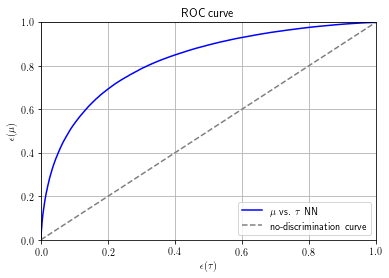

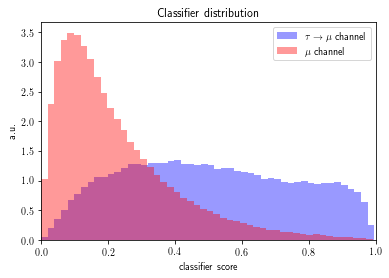

AUC = 0.8228408305623924
Gini index = 0.6456816611247849


<Figure size 432x288 with 0 Axes>

In [20]:
############################################################################
### TRAINING AND TESTING OF THE NN WITHOUTH THE VARIABLE WE WANT TO TEST ### 
############################################################################



### PREPARE DFs FOR TRAINING AND TEST ###

#these features are taken from the LHCb paper and have to be computed and added to the dataframes
features = [
    #'m2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    #'muE_Brf', #mu energy in the Bc rest frame
    #'q2', #squared 4momentum transfer to lepton sys (p_B - p_Jpsi^2)
    #'pT_miss',
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    'mu_charge' ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    'mu1_charge',
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
    'mu2_charge',
]

# concatenate the two samples
dataset = pd.concat([mu, tau],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])



### DEFINE THE MODEL ###

# define the model
model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



### TRAIN THE MODEL ###

# fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.5)



### TEST THE TRAINING OF THE MODEL ###

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
y = model.predict(x)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)



### ROC & SCORE CURVES ###

# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
plt.savefig('roc_no_test.pdf')
plt.show()
#plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.tau_pt>=0]
test_mu  = test[test.tau_pt <0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
plt.legend(loc='upper right')
plt.savefig('score_no_test.pdf')
plt.show()
plt.clf()

# compute the auc
auroc1 = auc(fpr, tpr)
print "AUC =", auroc1 

# compute Gini index
print "Gini index =", (auroc1-0.5)*2

Train on 48422 samples, validate on 48422 samples
Epoch 1/10
48422/48422 [==============================] - 9s 186us/step - loss: 0.1854 - acc: 0.9473 - val_loss: 0.1604 - val_acc: 0.9598
Epoch 2/10
48422/48422 [==============================] - 8s 171us/step - loss: 0.1529 - acc: 0.9616 - val_loss: 0.1578 - val_acc: 0.9600
Epoch 3/10
48422/48422 [==============================] - 8s 171us/step - loss: 0.1506 - acc: 0.9616 - val_loss: 0.1543 - val_acc: 0.9601
Epoch 4/10
48422/48422 [==============================] - 9s 181us/step - loss: 0.1489 - acc: 0.9620 - val_loss: 0.1530 - val_acc: 0.9604
Epoch 5/10
48422/48422 [==============================] - 8s 174us/step - loss: 0.1481 - acc: 0.9622 - val_loss: 0.1542 - val_acc: 0.9603
Epoch 6/10
48422/48422 [==============================] - 8s 174us/step - loss: 0.1474 - acc: 0.9624 - val_loss: 0.1512 - val_acc: 0.9608
Epoch 7/10
48422/48422 [==============================] - 9s 176us/step - loss: 0.1467 - acc: 0.9624 - val_loss: 0.1551 - 

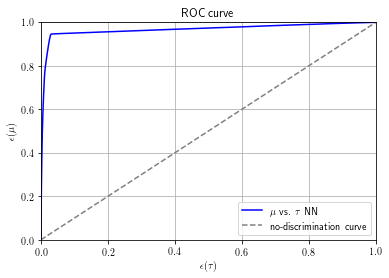

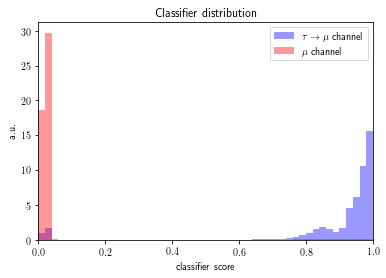

AUC = 0.9673062180597911
Gini index = 0.9346124361195822


<Figure size 432x288 with 0 Axes>

In [21]:
########################################################################
### TRAINING AND TESTING OF THE NN WITH THE VARIABLE WE WANT TO TEST ### 
########################################################################



### PREPARE DFs FOR TRAINING AND TEST ###

#these features are taken from the LHCb paper and have to be computed and added to the dataframes
features = [
    'm2_miss', #missing mass square (p_B - p_mu1 - p_mu2 - p_mu)^2
    #'muE_Brf', #mu energy in the Bc rest frame
    #'q2', #squared 4momentum transfer to lepton sys (p_B - p_Jpsi^2)
    #'pT_miss',
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    'mu_charge' ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    'mu1_charge',
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
    'mu2_charge',
]

# concatenate the two samples
dataset = pd.concat([mu, tau],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])



### DEFINE THE MODEL ###

# define the model
model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



### TRAIN THE MODEL ###

# fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.5)



### TEST THE TRAINING OF THE MODEL ###

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
y = model.predict(x)

# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)



### ROC & SCORE CURVES ###

# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
plt.savefig('roc_test.pdf')
plt.show()
plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.tau_pt>=0]
test_mu  = test[test.tau_pt <0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
plt.legend(loc='upper right')
plt.savefig('score_test.pdf')
plt.show()
plt.clf()

# compute the auc
auroc2 = auc(fpr, tpr)
print "AUC =", auroc2 

# compute Gini index
print "Gini index =", (auroc2-0.5)*2

In [22]:
print "AUC without test variable =", auroc1 
print "Gini index without test variable =", (auroc1-0.5)*2
print "\nAUC with test variable =", auroc2 
print "Gini index with test variable =", (auroc2-0.5)*2

AUC without test variable = 0.8228408305623924
Gini index without test variable = 0.6456816611247849

AUC with test variable = 0.9673062180597911
Gini index with test variable = 0.9346124361195822


In [16]:
#corr_test = pd.DataFrame(mu, columns=['q2','muE_Brf','pT_miss'])
#print corr_test.corr()

                  q2   pT_miss     mu_pt    mu_eta    mu_phi  mu_charge  \
q2          1.000000  0.157459  0.055076  0.002202 -0.001634        NaN   
pT_miss     0.157459  1.000000 -0.203002  0.000323 -0.001009        NaN   
mu_pt       0.055076 -0.203002  1.000000 -0.000020  0.000331        NaN   
mu_eta      0.002202  0.000323 -0.000020  1.000000 -0.005637        NaN   
mu_phi     -0.001634 -0.001009  0.000331 -0.005637  1.000000        NaN   
mu_charge        NaN       NaN       NaN       NaN       NaN        NaN   
mu1_pt     -0.134137  0.153931  0.076461 -0.001079 -0.000559        NaN   
mu1_eta     0.002426  0.001583  0.000093  0.883683 -0.006081        NaN   
mu1_phi    -0.000534 -0.002383  0.001377 -0.008727  0.500013        NaN   
mu1_charge -0.000411  0.000174 -0.000778 -0.002168  0.000842        NaN   
mu2_pt     -0.110657  0.056096  0.049227  0.000921 -0.002363        NaN   
mu2_eta     0.004240  0.001171  0.000133  0.790929 -0.006328        NaN   
mu2_phi     0.000771 -0.0